# 6 - Spectrograms

Loads depth-frequency-time data and then plots spectrograms for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import numpy as np
for i in range(2):
    %matplotlib notebook

In [10]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [11]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD
depth = ds[0].depth.values
f = ds[0].specf_s.values

## Depth-average PSD spectrograms (annual)

In [12]:
# WKB scale and depth average

WKB_u,WKB_v = [],[]
for i in range(n_seg):
    WKB_u_temp = ds[i].Sxxu_d / ds[0].WKB_scale
    WKB_v_temp = ds[i].Sxxv_d / ds[0].WKB_scale
    WKB_u.append(WKB_u_temp)
    WKB_v.append(WKB_v_temp)
    
depth_u,depth_v = [],[]
for i in range(n_seg):
    depth_u_temp = WKB_u[i].mean(dim='depth')
    depth_v_temp = WKB_v[i].mean(dim='depth')
    depth_u.append(depth_u_temp)
    depth_v.append(depth_v_temp)

In [13]:
# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2

Sxxu_w,Sxxv_w = [],[]
for i in range(n_seg):
    Sxxu_white = np.copy(depth_u[i])
    for j in range(len(ds[i].spect_s)):
        Sxxu_white[:,j] = Sxxu_white[:,j]*(f**2)
    Sxxv_white = np.copy(depth_v[i])
    for j in range(len(ds[i].spect_s)):
        Sxxv_white[:,j] = Sxxv_white[:,j]*(f**2)
    Sxxu_w.append(Sxxu_white)
    Sxxv_w.append(Sxxv_white)

<IPython.core.display.Javascript object>


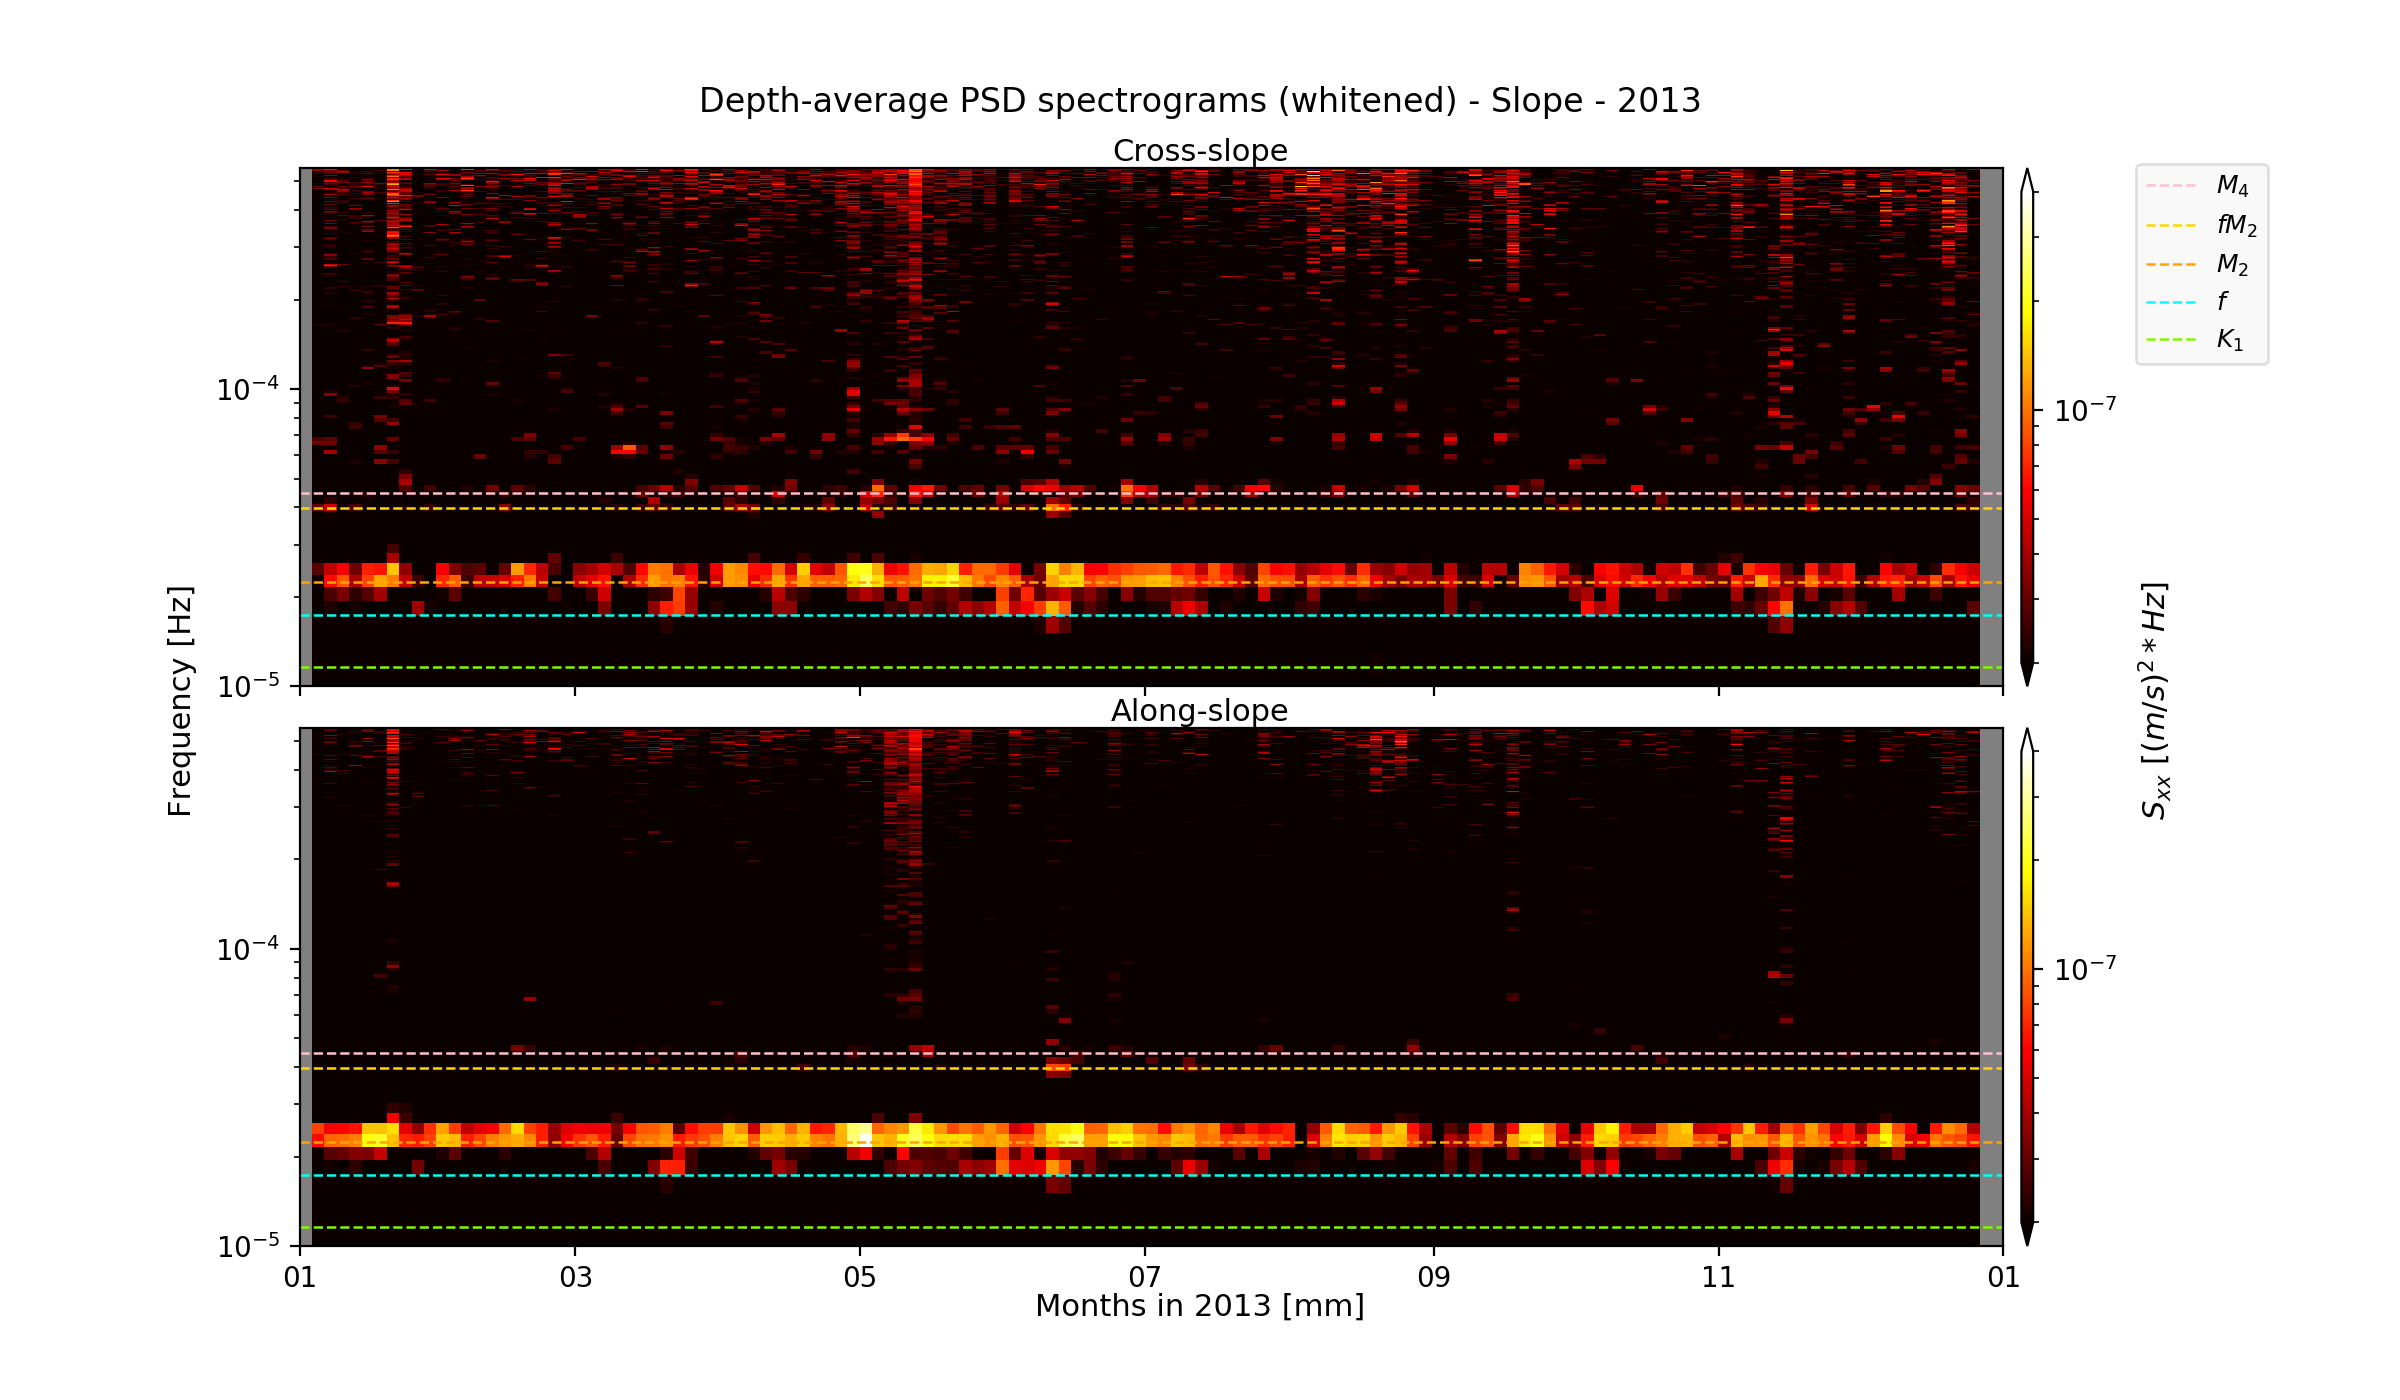

In [14]:
# plot spectrogram

fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(12,7), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.08)
fig.text(0.5, 0.92, f'Depth-average PSD spectrograms (whitened) - {adcp} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.07, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=11)
fig.text(0.89, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical', fontsize=11)
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center',fontsize=11)

if adcp == 'Slope':
    fig.text(0.5, 0.885, 'Cross-slope', ha='center', fontsize=11)
    fig.text(0.5, 0.485, 'Along-slope', ha='center', fontsize=11)
    vmin = 2e-8
    vmax = 4e-7
elif adcp == 'Axis55' or adcp == 'Axis75':
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=11)
    fig.text(0.5, 0.485, 'Along-canyon', ha='center', fontsize=11)
    vmin = 5e-8
    vmax = 1e-6

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, f, Sxxu_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
    im1 = ax1.pcolormesh(ds[i].spect_s, f, Sxxv_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')    

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

ax0.set_yscale('log')
ax0.set_ylim(1e-5,5.55e-4)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)

ax0.axhline(4.472e-5, color ='pink',ls='--',lw=0.9,label = "$M_4$")
ax0.axhline(3.968e-5, color ='gold',ls='--',lw=0.9,label = "$fM_2$")
ax0.axhline(2.236e-5, color ='orange',ls='--',lw=0.9,label = "$M_2$")
ax0.axhline(1.732e-5, color ='cyan',ls='--', lw=0.9,label = "$f$") 
ax0.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.9,label = "$K_1$") 
ax1.axhline(4.472e-5, color ='pink',ls='--',lw=0.9)
ax1.axhline(3.968e-5, color ='gold',ls='--',lw=0.9)
ax1.axhline(2.236e-5, color ='orange',ls='--',lw=0.9)
ax1.axhline(1.732e-5, color ='cyan',ls='--', lw=0.9) 
ax1.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.9) 

plt.subplots_adjust(right=0.88)
fig.legend(loc=(0.89,0.74), framealpha=0.6, facecolor='whitesmoke', fontsize=9, frameon=True)
plt.show()

plt.savefig(fname=f'./plots/spectro_plots/spectro_psd_{adcp}_{t_stamp}.pdf',format='pdf')

## Depth-average rotary spectrograms (annual)

In [15]:
# WKB scale and depth average

WKB_cw,WKB_ccw = [],[]
for i in range(n_seg):
    WKB_cw_temp = ds[i].cw_d / ds[0].WKB_scale
    WKB_ccw_temp = ds[i].ccw_d / ds[0].WKB_scale
    WKB_cw.append(WKB_cw_temp)
    WKB_ccw.append(WKB_ccw_temp)
    
depth_cw,depth_ccw = [],[]
for i in range(n_seg):
    depth_cw_temp = WKB_cw[i].mean(dim='depth')
    depth_ccw_temp = WKB_ccw[i].mean(dim='depth')
    depth_cw.append(depth_cw_temp)
    depth_ccw.append(depth_ccw_temp)

In [16]:
# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2

Sxxcw_w,Sxxccw_w = [],[]
for i in range(n_seg):
    Sxxcw_white = np.copy(depth_cw[i])
    for j in range(len(ds[i].spect_s)):
        Sxxcw_white[:,j] = Sxxcw_white[:,j]*(f**2)
    Sxxccw_white = np.copy(depth_ccw[i])
    for j in range(len(ds[i].spect_s)):
        Sxxccw_white[:,j] = Sxxccw_white[:,j]*(f**2)
    Sxxcw_w.append(Sxxcw_white)
    Sxxccw_w.append(Sxxccw_white)

<IPython.core.display.Javascript object>


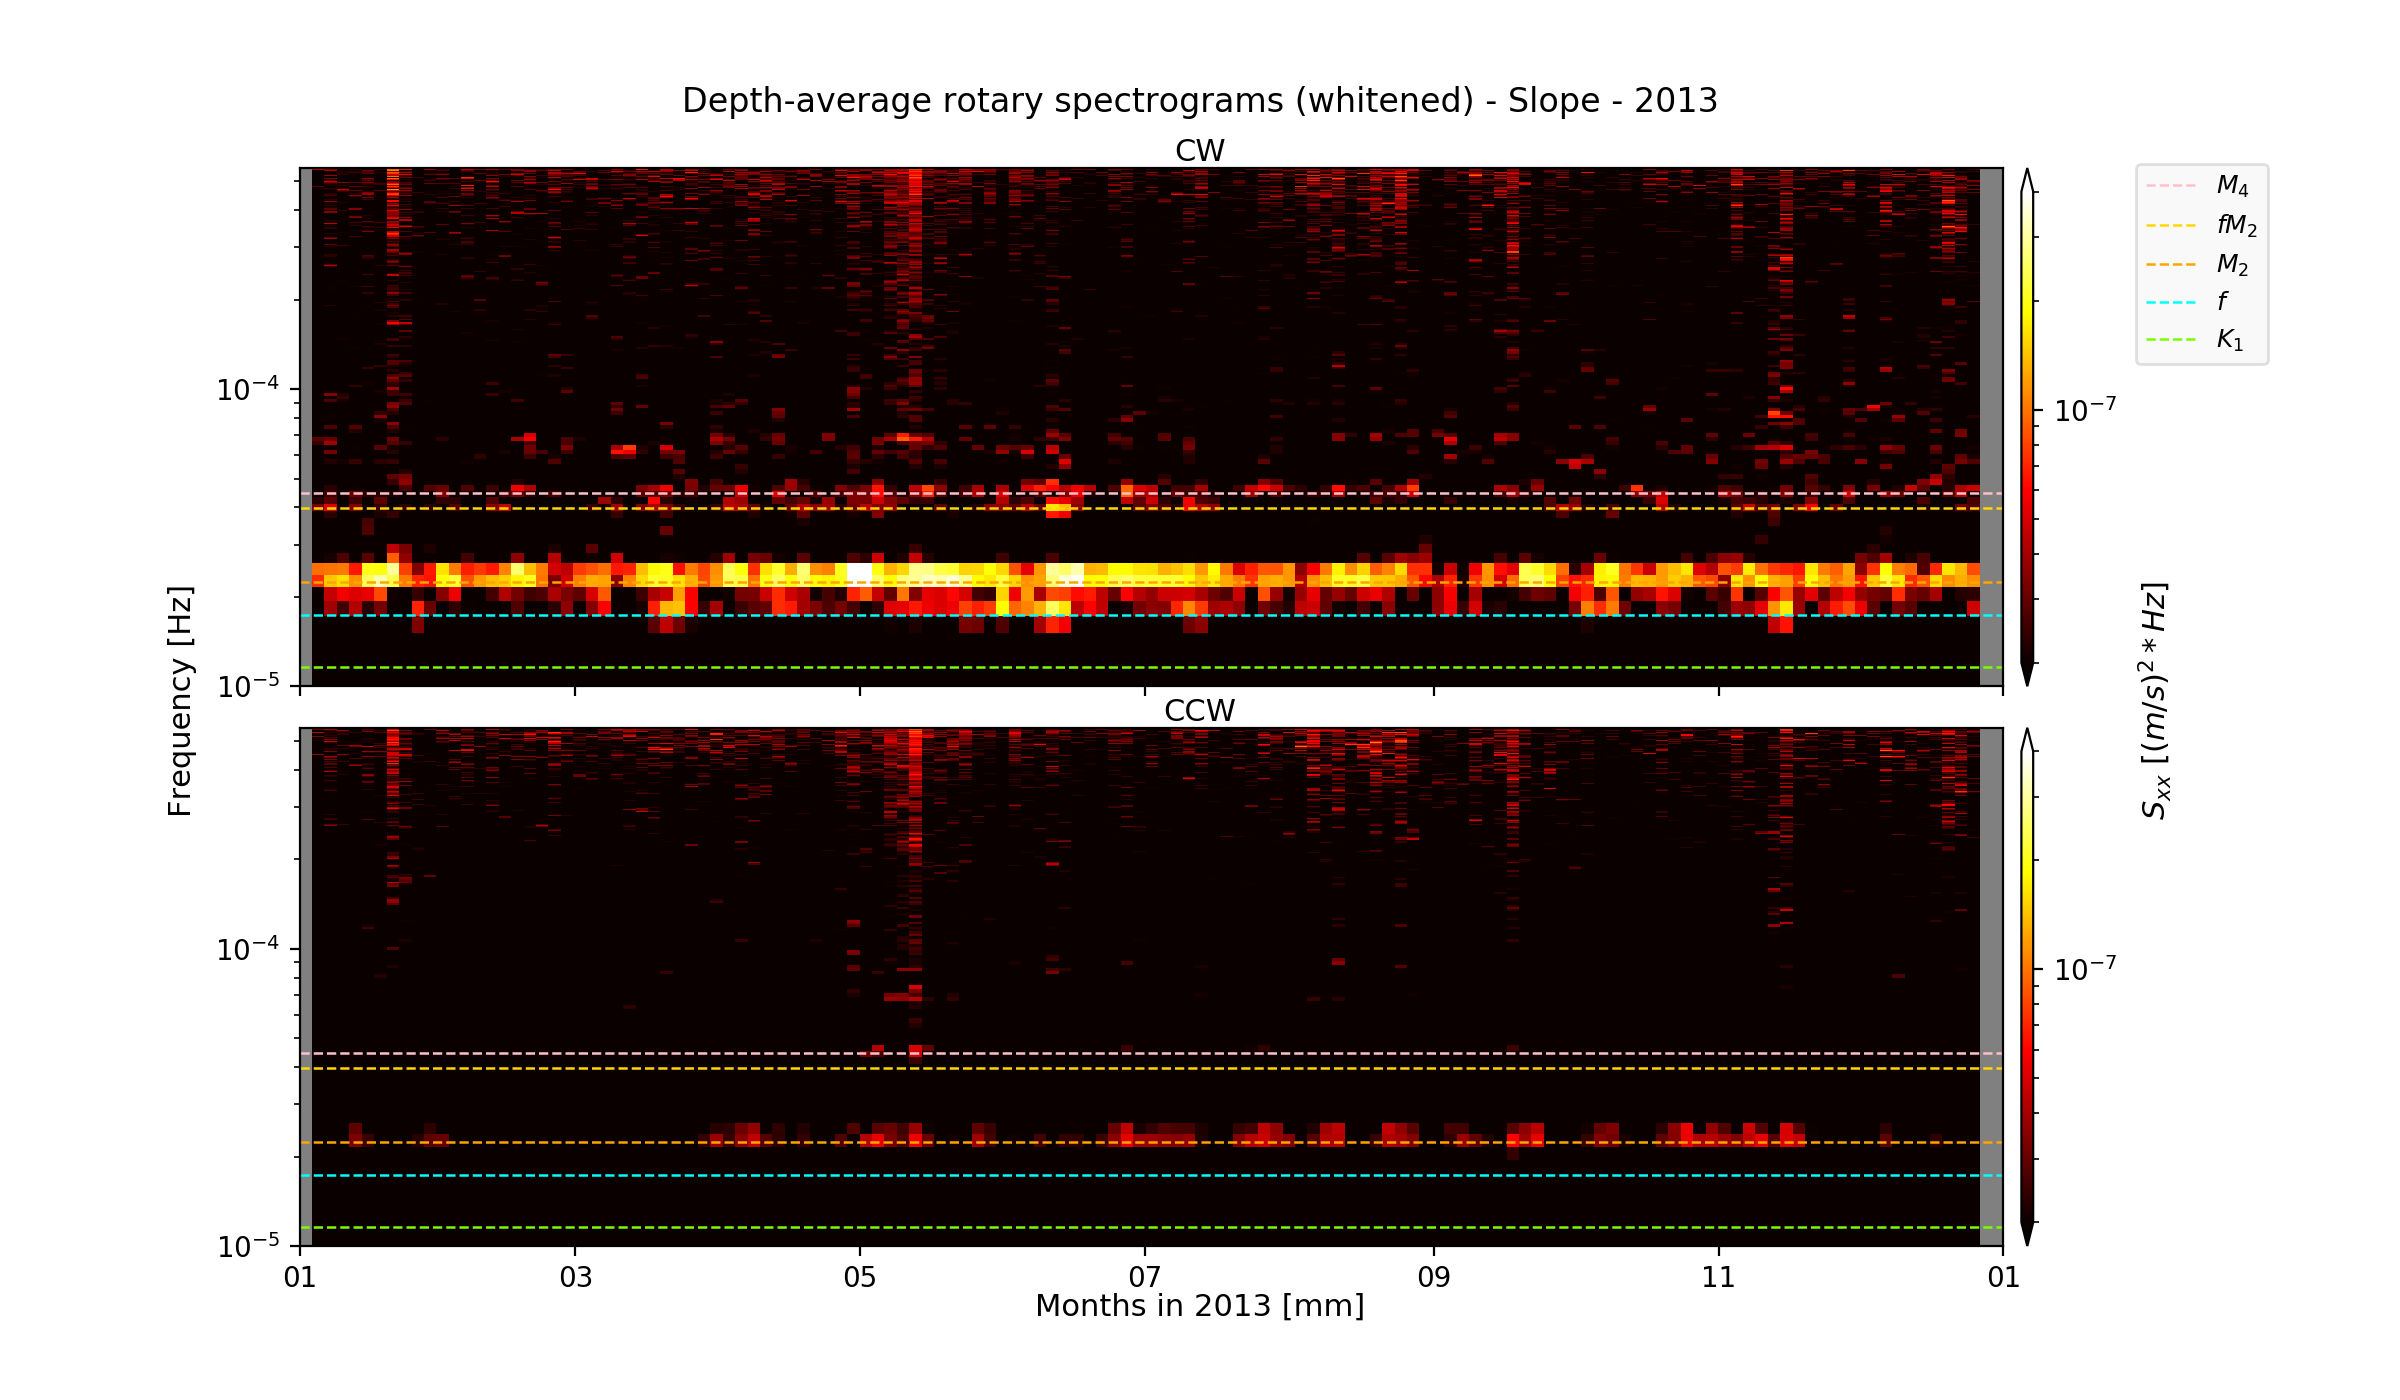

In [17]:
# plot spectrogram

fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(12,7), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.08)
fig.text(0.5, 0.92, f'Depth-average rotary spectrograms (whitened) - {adcp} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.07, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=11)
fig.text(0.89, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical', fontsize=11)
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center',fontsize=11)
fig.text(0.5, 0.885, 'CW', ha='center', fontsize=11)
fig.text(0.5, 0.485, 'CCW', ha='center', fontsize=11)

if adcp == 'Slope':
    vmin = 2e-8
    vmax = 4e-7
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = 5e-8
    vmax = 1e-6

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, f, Sxxcw_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
    im1 = ax1.pcolormesh(ds[i].spect_s, f, Sxxccw_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')    

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

ax0.set_yscale('log')
ax0.set_ylim(1e-5,5.55e-4)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)

ax0.axhline(4.472e-5, color ='pink',ls='--',lw=0.9,label = "$M_4$")
ax0.axhline(3.968e-5, color ='gold',ls='--',lw=0.9,label = "$fM_2$")
ax0.axhline(2.236e-5, color ='orange',ls='--',lw=0.9,label = "$M_2$")
ax0.axhline(1.732e-5, color ='cyan',ls='--', lw=0.9,label = "$f$") 
ax0.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.9,label = "$K_1$") 
ax1.axhline(4.472e-5, color ='pink',ls='--',lw=0.9)
ax1.axhline(3.968e-5, color ='gold',ls='--',lw=0.9)
ax1.axhline(2.236e-5, color ='orange',ls='--',lw=0.9)
ax1.axhline(1.732e-5, color ='cyan',ls='--', lw=0.9) 
ax1.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.9) 

plt.subplots_adjust(right=0.88)
fig.legend(loc=(0.89,0.74), framealpha=0.6, facecolor='whitesmoke', fontsize=9, frameon=True)
plt.show()

plt.savefig(fname=f'./plots/spectro_plots/spectro_rot_{adcp}_{t_stamp}.pdf',format='pdf')

## Depth comparison spectrograms (annual)

In [ ]:
# select depths & WKB scale

dupidx = 0                                     # upper depth
dlowidx = -1                                   # lower depth
dup_stamp = -depth[dupidx]                     # stamps for plotting
dlow_stamp = -depth[dlowidx]
print('Upper depth:',dup_stamp)
print('Lower depth:',dlow_stamp)

Sxxu_up,Sxxv_up,Sxxu_low,Sxxv_low = [],[],[],[]
for i in range(n_seg):
    Sxxu_up_temp = ds[i].Sxxu_d[dupidx,:,:] / ds[0].WKB_scale[dupidx].values                    # data for plotting, WKB scaled
    Sxxv_up_temp = ds[i].Sxxv_d[dupidx,:,:] / ds[0].WKB_scale[dupidx].values
    Sxxu_low_temp = ds[i].Sxxu_d[dlowidx,:,:].values / ds[0].WKB_scale[dlowidx].values
    Sxxv_low_temp = ds[i].Sxxv_d[dlowidx,:,:].values / ds[0].WKB_scale[dlowidx].values
    Sxxu_up.append(Sxxu_up_temp)
    Sxxv_up.append(Sxxv_up_temp)
    Sxxu_low.append(Sxxu_low_temp)
    Sxxv_low.append(Sxxv_low_temp)

In [ ]:
# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2

Sxxu_up_w,Sxxv_up_w,Sxxu_low_w,Sxxv_low_w = [],[],[],[]
for i in range(n_seg):
    Sxxu_up_white = np.copy(Sxxu_up[i])
    for j in range(len(ds[i].spect_s)):
        Sxxu_up_white[:,j] = Sxxu_up_white[:,j]*(f**2)
    Sxxv_up_white = np.copy(Sxxv_up[i])
    for j in range(len(ds[i].spect_s)):
        Sxxv_up_white[:,j] = Sxxv_up_white[:,j]*(f**2)
    Sxxu_low_white = np.copy(Sxxu_low[i])
    for j in range(len(ds[i].spect_s)):
        Sxxu_low_white[:,j] = Sxxu_low_white[:,j]*(f**2)
    Sxxv_low_white = np.copy(Sxxv_low[i])
    for j in range(len(ds[i].spect_s)):
        Sxxv_low_white[:,j] = Sxxv_low_white[:,j]*(f**2)
    Sxxu_up_w.append(Sxxu_up_white)
    Sxxv_up_w.append(Sxxv_up_white)
    Sxxu_low_w.append(Sxxu_low_white)
    Sxxv_low_w.append(Sxxv_low_white)

In [ ]:
# plot spectrogram

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
(ax0,ax1),(ax2,ax3) = axs
fig.subplots_adjust(hspace=0.07, wspace=0.05)
fig.text(0.5, 0.92, f'Spectrograms (whitened) - {adcp} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.07, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=11)
fig.text(0.91, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical', fontsize=11)
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center',fontsize=11)
fig.text(0.125,0.882,f'{dup_stamp} m', fontsize=11)
fig.text(0.125,0.483,f'{dlow_stamp} m', fontsize=11)

if adcp == 'Slope':
    ax0.set_title('Cross-slope')
    ax1.set_title('Along-slope')
    vmin = 3e-8
    vmax = 5e-7
elif adcp == 'Axis55' or adcp == 'Axis75':
    ax0.set_title('Cross-canyon')
    ax1.set_title('Along-canyon')
    vmin = 5e-8
    vmax = 1e-6


for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, f, Sxxu_up_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
    im1 = ax1.pcolormesh(ds[i].spect_s, f, Sxxv_up_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
    im2 = ax2.pcolormesh(ds[i].spect_s, f, Sxxu_low_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')
    im3 = ax3.pcolormesh(ds[i].spect_s, f, Sxxv_low_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')    

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
ax2.patch.set_facecolor('grey')
ax3.patch.set_facecolor('grey')

ax0.set_yscale('log')
ax0.set_ylim(1e-5,5.55e-4)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
ax0.xaxis.set_major_locator(plt.MaxNLocator(6))

ax0.axhline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$")
ax0.axhline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$")
ax0.axhline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$")
ax0.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$") 
ax0.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$") 
ax1.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax1.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax1.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax1.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax1.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 
ax2.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax2.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax2.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax2.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax2.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 
ax3.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax3.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax3.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax3.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax3.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 

plt.subplots_adjust(right=0.88)
fig.legend(loc=(0.91,0.756), framealpha=0.6, facecolor='whitesmoke', fontsize=9, frameon=True)
plt.show()

plt.savefig(fname=f'./plots/spectro_plots/spectro_{adcp}_{t_stamp}.pdf',format='pdf')